In [2]:
import pandas as pd

from battery_optimise import *
from check import check_submission
from algo_utils import plot_actions

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format',lambda x : '%.2f' % x)

### Simulate battery optimisation

In [3]:
# Read data
data = pd.read_csv("../data/nsw.csv")
data['time'] = pd.to_datetime(data['time'])

In [4]:
result = battery_optimisation(data.time, data.spot_price, solver='glpk')

In [4]:
result.to_csv('test_result.csv')

##### Visualise result

In [5]:
# chart_data = pd.read_csv('test_result.csv', index_col='time', parse_dates=['time'])

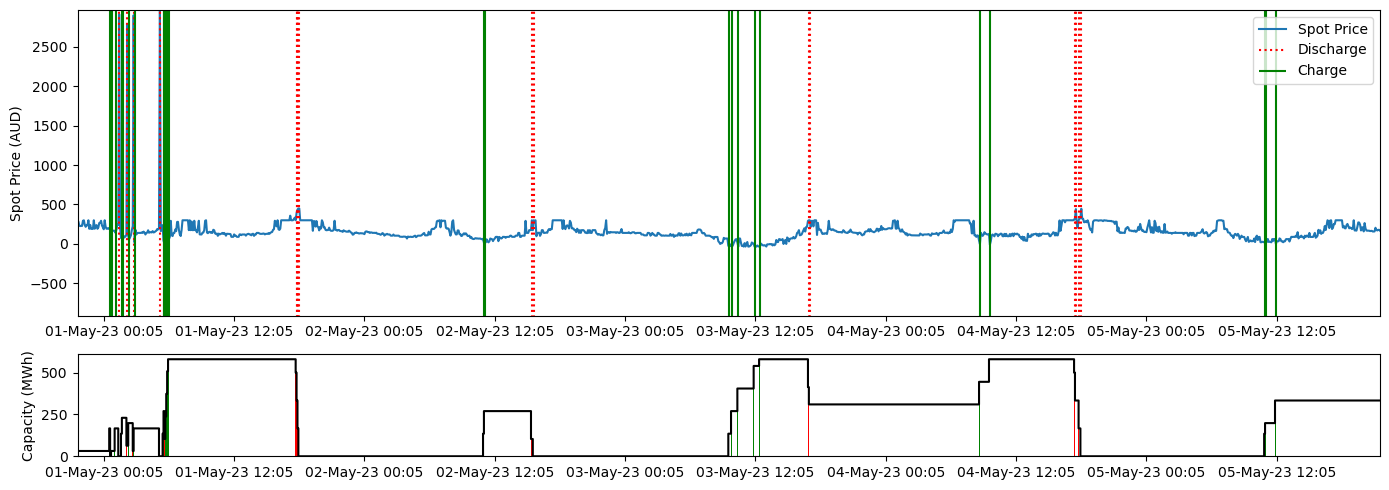

In [5]:
start_day = 90
days_to_plot = 5
start = int(288*(start_day-1))
end = int(288*(start_day+days_to_plot-1))
plot_actions(result.spot_price, result.power, opening_capacity=result.opening_capacity, start=start, end=end)

In [13]:
288*(start_day+days_to_plot-1)

5616.0

In [21]:
result['power'].index[5]

Timestamp('2023-02-01 00:30:00')

In [11]:
# Save result to csv
result.to_csv('../result/result_perfect_foresight.csv')
result

,spot_price,power,market_dispatch,opening_capacity,cycles,revenue
time,,,,,,
2023-02-01 00:05:00,120.06,-300.00,-150.00,0.00,0.00,-18172.58
2023-02-01 00:10:00,127.05,0.00,0.00,135.00,0.00,0.00
2023-02-01 00:15:00,125.04,0.00,0.00,135.00,0.00,0.00
2023-02-01 00:20:00,128.00,0.00,0.00,135.00,0.00,0.00
2023-02-01 00:25:00,120.06,0.00,0.00,135.00,0.00,0.00
...,...,...,...,...,...,...
2024-02-29 23:40:00,88.00,0.00,0.00,0.00,471.60,0.00
2024-02-29 23:45:00,91.40,0.00,0.00,0.00,471.60,0.00
2024-02-29 23:50:00,99.27,0.00,0.00,0.00,471.60,0.00


##### Assumptions:


- **Perfect foresight** on spot price <br>
- Battery does not degrade throughout the optimisation horizon <br>
- Battery cannot charge and discharge concurrently 

To formulate the algorithm, we've treated the battery system as a linear programming problem. The following are the objective function, parameters, decision variables and operational constraint for the linear programming model. The objective function is the objective we would like to maximise, which is the revenue over the time horizon of optimisation. <br>
- The objective function:<br>
$\sum_{t=1}^{T}{P_t}(\frac{D_t{E}}{2}{\eta}-\frac{C_t}{2{\eta}})$ <br>
<br>
- Parameters: <br>
$T$: Time horizon of arbitrage <br>
$P_t$: Spot price at time t <br>
$E$: Charge and discharge efficiency of the battery <br>
$\eta$: Marginal Loss Factor <br>
<br>
- Decision Variables: <br>
$Capacity_t$: Opening Capacity at time t <br>
$C_t$: Charge Power at time t <br>
$D_t$: Discharge Power at time t <br>
<br>
- Opertaion Constraint: <br>
$Capacity_t = {Capacity_{t-1}} + \frac{C_t}{2}E - \frac{D_t}{2}$ <br>
$0 \leq {Capacity_t} \leq 580, \forall t \in T$ <br>
$0 \leq {C_t} \leq 300, \forall t \in T$ <br>
$0 \leq {D_t} \leq 300, \forall t \in T$ <br>
$D_t \leq \frac{Capacity_t\times{E}}{2}$ <br>
$when\; P_t < 0,\:D_t = 0$ <br>